In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm

tqdm.pandas

<bound method tqdm.pandas of <class 'tqdm.std.tqdm'>>

In [2]:
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from modules import cleaning, preprocess, word2vec_model

In [4]:
df = pd.read_csv("../data/train.csv")

### Exploratory Data Analysis

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<AxesSubplot:xlabel='is_duplicate'>

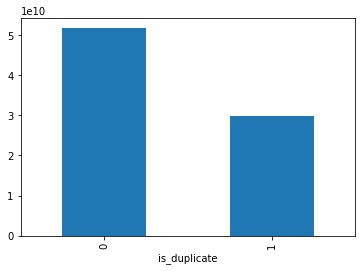

In [7]:
df.groupby("is_duplicate")["id"].sum().plot.bar()

### Preprocessing

In [8]:
df = preprocess.get_cleaned_data(df)

Group all the questions together

In [9]:
df.head()

,cleaned_q1,cleaned_q2,is_duplicate
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,"[story, kohinoor, koh, noor, diamond]","[would, happen, indian, government, stole, koh...",0
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,"[mentally, lonely, solve]","[find, remainder, math, math, divided]",0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


Instantiate a new word2vec model given all the questions

In [10]:
questions = preprocess.get_all_questions(df)

Intersect the word2vec model against google's word2vec model and apply training to the new model

In [11]:
data_path = "../data/word2vec_model"
model = word2vec_model.load_model(data_path)
if model == None:
    model = word2vec_model.create_model(questions)
    word2vec_model.save_model(model, data_path)

#### Reasearch
 - Suggests that multiplying the vectors with their TF-IDF scores will give the best results for a 'sentence' vector

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

In [13]:
sample = df.sample(10_000, random_state=100).reset_index(drop=True)


X = sample[["cleaned_q1", "cleaned_q2"]]
y = sample[["is_duplicate"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, StringLookup, LSTM, Dropout, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [15]:
vocab = model.wv.index_to_key
weights = model.wv.vectors

In [16]:
weights

array([[-0.12695312,  0.02197266,  0.28710938, ..., -0.1015625 ,
        -0.09033203,  0.08837891],
       [-0.6756524 ,  0.30152553, -1.008109  , ..., -0.35299873,
        -0.5013534 , -1.7103904 ],
       [-0.234375  , -0.07177734,  0.01055908, ..., -0.09521484,
        -0.11621094, -0.11230469],
       ...,
       [ 0.6419923 , -0.23743276,  0.3387453 , ..., -0.23692861,
        -0.18211327, -0.12591651],
       [-0.01422119,  0.359375  , -0.10791016, ..., -0.05322266,
         0.09765625,  0.08398438],
       [ 0.06296369,  0.01724202,  0.20674233, ..., -0.16718297,
        -0.04888789,  0.1357694 ]], dtype=float32)

In [17]:
s_layer = StringLookup(vocabulary=vocab)


2022-06-30 21:49:16.699907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-30 21:49:16.699937: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-30 21:49:16.699955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (desktop): /proc/driver/nvidia/version does not exist
2022-06-30 21:49:16.700207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
def f(x):
    try:
        v = s_layer(x)
        return v
    except:
        return 0
    

In [19]:
t= X_train["cleaned_q1"].progress_apply(f)
t2 = X_train["cleaned_q2"].progress_apply(f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [03:41<00:00, 36.05it/s]


In [20]:
t_pad = tf.keras.preprocessing.sequence.pad_sequences(t, padding="post", maxlen=26)
t2_pad = tf.keras.preprocessing.sequence.pad_sequences(t, padding="post", maxlen=26)

In [21]:
combined = np.stack((t_pad, t2_pad), axis=1)

In [22]:
combined = combined.reshape(combined.shape[0], combined.shape[1]*combined.shape[2])
combined.shape

(8000, 52)

In [23]:
test_1 = X_test["cleaned_q1"].progress_apply(f)
test_2 = X_test["cleaned_q2"].progress_apply(f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 36.29it/s]


In [24]:
test_1_pad = tf.keras.preprocessing.sequence.pad_sequences(test_1, padding="post", maxlen=26)
test_2_pad = tf.keras.preprocessing.sequence.pad_sequences(test_2, padding="post", maxlen=26)

In [25]:
test_combined = np.stack((test_1_pad, test_2_pad), axis=1)
test_combined = test_combined.reshape(test_combined.shape[0], test_combined.shape[1]*test_combined.shape[2])
test_combined.shape

(2000, 52)

In [39]:
clear_session()

In [40]:
embed_layer= Embedding(
    input_dim=len(vocab),
    output_dim=300,
    weights=[weights],
    trainable=False,
)

nn = Sequential()
nn.add(embed_layer)
nn.add(LSTM(256, activation="relu"))
nn.add(Dropout(0.2))
nn.add(Flatten())
nn.add(Dense(128, activation="relu"))
nn.add(Dense(64, activation="relu"))
nn.add(Dense(2, activation="sigmoid"))

In [41]:
nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [42]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         7602000   
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [43]:
history = nn.fit(combined, to_categorical(y_train), batch_size=4, epochs=25, steps_per_epoch=250, validation_data=[test_combined, to_categorical(y_test)], callbacks=[EarlyStopping(patience=5)])

Epoch 1/25
250/250 [==============================] - 25s 94ms/step - loss: 43871.5117 - acc: 0.5980 - val_loss: 0.9334 - val_acc: 0.6295
Epoch 2/25
250/250 [==============================] - 23s 92ms/step - loss: 1.0944 - acc: 0.5740 - val_loss: 0.8943 - val_acc: 0.6295
Epoch 3/25
250/250 [==============================] - 23s 92ms/step - loss: 0.8739 - acc: 0.6010 - val_loss: 0.7244 - val_acc: 0.6210
Epoch 4/25
250/250 [==============================] - 23s 91ms/step - loss: 0.7822 - acc: 0.6200 - val_loss: 0.7755 - val_acc: 0.5085
Epoch 5/25
250/250 [==============================] - 23s 93ms/step - loss: 0.7654 - acc: 0.5580 - val_loss: 0.6829 - val_acc: 0.6085
Epoch 6/25
250/250 [==============================] - 23s 92ms/step - loss: 0.7039 - acc: 0.6170 - val_loss: 0.6813 - val_acc: 0.6275
Epoch 7/25
250/250 [==============================] - 22s 90ms/step - loss: 0.6820 - acc: 0.6330 - val_loss: 0.6622 - val_acc: 0.6295
Epoch 8/25
250/250 [==============================] - 23s 